In [113]:
import csv
import copy
import numpy as np
import json
import re, os
import time
import datetime

dep_id = '1182023'

reward_data_file_path = '../data/{}/reward_data.csv'.format(dep_id)
reward_data_clean_file_path = '../data/{}/reward_data_clean.csv'.format(dep_id)

### Read Reward Data
The read files of reward_data contains 11 fileds:
* SpeakerID, TimeSent, TimeReceived', Response, Question, QuestionType, QuestionName, Reactive, SentTimes, ConnectionError, dep_id
The saved files of reward_data_clean contains 10 fields:
* TimeSent, TimeReceived', Response, Question, QuestionType, QuestionName, Reactive, SentTimes, ConnectionError, dep_id

#### Clean Reward Data & Get Some Statistics

In [114]:
# ## Remove Duplication
# with open(reward_data_file_path, newline='') as f:
#     with open(reward_data_clean_file_path, 'w') as f_out:
#         print("read file: ", reward_data_file_path)
#         print("write file; ", reward_data_clean_file_path)
#         reward_data_reader = csv.reader(f)
#         cnt_line = 0
#         prev_line_timesent = None
#         prev_line = None
#         cnt_line_duplicate = 0
#         cnt_line_sametimestamp = 0
#         for line in reward_data_reader:
#             cnt_line += 1                           # line 0 represents the head line
#             if cnt_line > 1:
#                 # line[0] is speaker_ID and we will ignore it
#                 if prev_line_timesent is not None and line[1] == prev_line_timesent:
#                     # This suggest that the current line might be identical to the previous line
#                     try:
#                         # If this line is same as the previous line, we skip it
#                         assert line[3] == prev_line[3]      # Response 
#                         assert line[4] == prev_line[4]      # Question
#                         assert line[5] == prev_line[5]      # Question Type
#                         assert line[6] == prev_line[6]      # Question Name
#                         assert line[7] == prev_line[7]      # Reactive
#                         assert line[8] == prev_line[8]      # SentTimes
#                         assert line[9] == prev_line[9]      # ConnectionError
#                         assert line[10] == prev_line[10]    # dep-id
#                         cnt_line_duplicate += 1
#                     except:
#                         # Otherwise, we still save it into the file
#                         print(cnt_line, line)
#                         cnt_line_sametimestamp += 1
#                         # write this line to the new file
#                         f_out.write(','.join(
#                             [line[1], line[2], '"'+line[3]+'"', '"'+line[4]+'"',
#                              line[5], line[6], line[7], line[8], line[9], line[10]])
#                              )
#                         f_out.write('\n')

#                     continue

#                 else:
#                     # write this line to the new file
#                     f_out.write(','.join(
#                         [line[1], line[2], '"'+line[3]+'"', '"'+line[4]+'"',
#                          line[5], line[6], line[7], line[8], line[9], line[10]])
#                          )
#                     f_out.write('\n')
#             else:
#                 # write the first line (i.e. header) into the file
#                 f_out.write(','.join(line[1:]))
#                 f_out.write('\n')
#             prev_line_timesent = line[1]
#             prev_line = copy.deepcopy(line)
#         print("Number of duplicate lines: {}".format(cnt_line_duplicate))
#         print("Number of line with same timestamp as previous line: {}".format(cnt_line_sametimestamp))

In [115]:
baseline_period_end_line = 0
with open(reward_data_clean_file_path, newline='') as f_clean:
    print("read file: ", reward_data_clean_file_path)
    reward_data_reader = csv.reader(f_clean)
    cnt_line = 0
    for line in reward_data_reader:
            cnt_line += 1                           # line 0 represents the head line
            if cnt_line > 1:
                question_name = line[5]
                if 'baseline' in question_name:
                    baseline_period_end_line = cnt_line
                if 'daytime' in question_name and 'baseline' not in question_name:
                    break

    print('baseline period ends at line: {}'.format(baseline_period_end_line))

read file:  ../data/1182023/reward_data_clean.csv
baseline period ends at line: 0


In [119]:
baseline_period_end_line = 943

There are 4 types of scenarios:
1. daytime:checkin:proactive:1 send 3 times + no response + missed:recomm:1
2. daytime:checkin:proactive:1 send <= 3 times + response + daytime:recomm send 3 times + no response + missed:recomm:1
3. daytime:checkin:proactive:1 send <= 3 times + response + daytime:recomm send <= 3 times + response + daytime:postrecomm:implement:1 send 3 times + no response
4. daytime:checkin:proactive:1 send <= 3 times + response + daytime:recomm send <= 3 times + response + daytime:postrecomm:implement:1 send <= 3 times + response + daytime:postrecomm:helpfulyes:1 or daytime:postrecomm:helpfulno:1

#### Follow-up Questions Response Rate

I wonder if we can also calculate the percentage of ‘no response’ to the post-recommendation questions. For example, to calculate this rate, we may focus only on the rate of whether the participant did not answer the post-recommendation responses out of the number of sending post-recommendation responses. I am only interested in A and B scenarios in this case (A = responded, B = not responded). Scenarios C and D would not be included in this case as we did not give him messages about post-recommendation responses.

In [120]:
def compute_period_response_rate(start_line, end_line):

    # Read data files
    with open(reward_data_clean_file_path, newline='') as f_clean:
        print("Read file: ", reward_data_clean_file_path)
        print("Baseline period ends at line: {}, we will count proactive/reactive message statistics after that line.".format(baseline_period_end_line))
        reward_data_reader = csv.reader(f_clean)
        cnt_line = 0

        send_recomm_tips_lines = []
        respond_recomm_tips_lines = []

        proactive_recomm = False
        reactive_recomm = False
        request_recomm = False

        proactive_recomm_start_line = -1
        proactive_recomm_end_line = -1
        reactive_recomm_start_line = -1
        reactive_recomm_end_line = -1
        request_recomm_start_line = -1
        request_recomm_end_line = -1

        proactive_recomm_msgs = []
        reactive_recomm_msgs = []
        request_recomm_msgs = []

        proactive_checkin_response = False          # whether the proactive check-in msg receive response
        reactive_checkin_response = False           # whether the reactive check-in msg receive response
        request_button_response = False             # whether the request button msg receive response
        proactive_recomm_response = False           # whether the proactive recomm msg receive response
        reactive_recomm_response = False            # whether the reactive recomm msg receive response
        request_recomm_response = False             # whether the request button recomm msg receive response 
        proactive_postrecomm_response = False       # whether the proactive post-recomm msg receive response
        reactive_postrecomm_response = False        # whether the reactive post-recomm msg receive response
        request_postrecomm_response = False         # whether the request button post-recomm msg receive response

        send_recomm_msg = False                     # whether the recomm msg is sent (regardless of proactive/reactive/request)
        send_postrecomm_msg = False                 # whether the post-recomm msg is sent (regardless of proactive/reactive/request)

        num_proactive_checkins_msg_send = []        # store the number of attemps that we send the check_in:proactive:1
        num_reactive_checkins_msg_send = []         # store the number of attemps that we send the check_in:reactive:1
        num_reactive_2_checkins_msg_send = []       # store the number of attemps that we send the check_in:reactive:2
        num_proactive_checkins_msg_send_with_response = []  # store the number of attemps that we send the check_in:proactive:1 with response
        num_reactive_checkins_msg_send_with_response = []   # store the number of attemps that we send the check_in:reactive:1 with response
        num_reactive_2_checkins_msg_send_with_response = [] # store the number of attemps that we send the check_in:reactive:2 with response

        cnt_proactive_checkins_msg_send = 0         # number of check_in:proactive:1 msgs we send (multiple attemps count as 1)
        cnt_reactive_checkins_msg_send = 0          # number of check_in:reactive:1 msgs we send (multple attemps count as 1)
        cnt_reactive_2_checkins_msg_send = 0        # number of check_in:reactive:2 msgs we send (multiple attemps count as 1)
        cnt_request_button_mgs_send = 0             # number of request button msgs we send
        cnt_proactive_checkins_msg_response = 0     # number of proactive check-in msgs we receive response
        cnt_reactive_checkins_msg_reponse = 0       # number of reactive check-in msgs we receive response
        cnt_request_button_mgs_response = 0         # number of request button msgs we receive response

        cnt_proactive_recomm_send = 0               # number of proactive recomm msg we send (multiple attemps count as 1)
        cnt_proactive_recomm_response = 0           # number of proactive recomm msg we receive response
        cnt_reactive_recomm_send = 0                # number of reactive recomm msg we send (multiple attemps count as 1)
        cnt_reactive_recomm_response = 0            # number of reactive recomm msg we receive response
        cnt_request_recomm_send = 0                 # number of request button recomm msg we send
        cnt_request_recomm_response = 0             # number of request button recomm msg we receive reponse

        num_proactive_recomm_msg_send = []          # store the number of attemps that we send the proactive recomm msgs
        num_reactive_recomm_msg_send = []           # store the number of attemps that we send the reactive recomm msgs
        num_request_recomm_msg_send = []            # store the number of attemps that we send the request button recomm msgs
        num_proactive_recomm_msg_send_w_res = []    # store the number of attemps that we send the proactive recomm msgs with response
        num_reactive_recomm_msg_send_w_res = []     # store the number of attemps that we send the reactive recomm msgs with response
        num_request_recomm_msg_send_w_res = []      # store the number of attemps that we send the request button recomm msgs with response

        cnt_proactive_postrecomm_send = 0           # number of proactive post-recomm msg we send
        cnt_proactive_postrecomm_response = 0       # number of proactive post-recomm msg we receive
        cnt_reactive_postrecomm_send = 0            # number of reactive post-recomm msg we send
        cnt_reactive_postrecomm_response = 0        # number of reactive post-recomm msg we receive
        cnt_request_postrecomm_send = 0             # number of request recomm post-recomm msg we send
        cnt_request_postrecomm_response = 0         # number of request recomm post-recomm msg we receive


        cnt_reactive_response = [0, 0, 0, 0, 0]     # response cnt for the answer -1, 0, 1, 2, 3
        reactive_response_answer = [False, False, False, False, False]

        for line in reward_data_reader:
            cnt_line += 1                           # line 0 represents the head line
            if cnt_line < start_line:
                continue
            if cnt_line > end_line:
                break
            if cnt_line != 1:
                question_name = line[5]                 # question name, str
                sent_times = int(line[7])               # sent times, int

                if 'request:button' in question_name and cnt_line < baseline_period_end_line:
                    # In baseline period, there will be request button msgs, and we will not count them.
                    continue

                ''' How can we know that we encounter a new message? There are several conditions.
                1. A new proactive recomm start. We need to first send the proactive check-in msg
                    --> question_name is 'daytime:check_in:proactive:1' and send_times = 1
                2. A new reactive recomm start. We need to first send the reactive check=in msg
                    --> question_name is 'daytime:check_in:reactive:1' and send_times = 1
                3. All the recommendations in the queue are cleared and we place the request button on the screen.
                    --> question_name is 'request:button:1' and send_times = 1 and also we have finished proactive and reactive recomm procedures and we should have proactive_recomm = False and reactive_recomm = False
                4. Missed recommendation msg being send with no respond
                    --> question_name is 'missed:recomm:1' and response is not 0
                5. Schduled event msgs being sent, including morning/evening/weekly messages.
                    --> question_name contains 'morning', 'evening', or 'weekly'
                '''

                if ('daytime:check_in:proactive:1' in question_name and sent_times == 1) or ('daytime:check_in:reactive:1' in question_name and sent_times == 1) or ('request:button' in question_name and sent_times == 1 and proactive_recomm is False and reactive_recomm is False) or ('morning' in question_name) or ('evening' in question_name) or ('weekly:' in question_name) or ('missed' in question_name and int(float(line[2])) != 0):
                    # If previously we are inside a proactive recommendation procedure
                    if proactive_recomm is True:
                        # clear the proactive-recomm msg statistics
                        proactive_recomm_end_line = cnt_line - 1
                        proactive_recomm_msgs.append(
                            [proactive_recomm_start_line, proactive_recomm_end_line,
                            proactive_checkin_response, send_recomm_msg, proactive_recomm_response,
                            send_postrecomm_msg, proactive_postrecomm_response]
                        )
                        if proactive_checkin_response:
                            cnt_proactive_checkins_msg_response += 1
                            num_proactive_checkins_msg_send_with_response.append(num_proactive_checkins_msg_send[-1])
                        if send_recomm_msg:
                            cnt_proactive_recomm_send += 1
                        if proactive_recomm_response:
                            cnt_proactive_recomm_response += 1
                        if send_postrecomm_msg:
                            cnt_proactive_postrecomm_send += 1
                        if proactive_postrecomm_response:
                            cnt_proactive_postrecomm_response += 1

                        if (proactive_checkin_response) and not send_recomm_msg:
                            print('[proactive] check-in msg receive response but no proactive recommendation messages were sent. ', proactive_recomm_start_line, proactive_recomm_end_line, proactive_checkin_response, send_recomm_msg, proactive_recomm_response, send_postrecomm_msg, proactive_postrecomm_response)
                            print('\n')

                        proactive_recomm = False
                        proactive_checkin_response = False
                        send_recomm_msg = False
                        proactive_recomm_response = False
                        send_postrecomm_msg = False
                        proactive_postrecomm_response = False

                    # If previously we are inside a reactive recommendation procedure
                    if reactive_recomm is True:
                        # clear the reactive-recomm msg statistics
                        reactive_recomm_end_line = cnt_line - 1
                        reactive_recomm_msgs.append(
                            [reactive_recomm_start_line, reactive_recomm_end_line,
                            reactive_checkin_response, send_recomm_msg, reactive_recomm_response,
                            send_postrecomm_msg, reactive_postrecomm_response]
                        )
                        if reactive_checkin_response:
                            # only consider the check_in:reactive:1 msg
                            cnt_reactive_checkins_msg_reponse += 1
                            num_reactive_checkins_msg_send_with_response.append(num_reactive_checkins_msg_send[-1])
                        if send_recomm_msg:
                            cnt_reactive_recomm_send += 1
                        if reactive_recomm_response:
                            cnt_reactive_recomm_response += 1
                        if send_postrecomm_msg:
                            cnt_reactive_postrecomm_send += 1
                        if reactive_postrecomm_response:
                            cnt_reactive_postrecomm_response += 1

                        # cnt the number of different answers to the check_in:reactive:1 msg
                        cnt_ans = 0
                        for i in range(1,5):
                            if reactive_response_answer[i]:
                                cnt_ans += 1
                        assert cnt_ans < 2      # make sure that at most 1 answer is selected from ans-1 to ans-4
                        if cnt_ans == 1:
                            # we have a response from the check_in:reactive:1 msg
                            for i in range(1,5):
                                # update the counter at the position of the corresponding answer
                                if reactive_response_answer[i]:
                                    cnt_reactive_response[i] += 1
                        else:
                            # we didn't get a response from the check_in:reactive:1 msg 
                            assert reactive_response_answer[0]  # make sure that the position 0 of this vector is True
                            cnt_reactive_response[0] += 1       # update the counter

                        reactive_recomm = False
                        reactive_checkin_response = False
                        send_recomm_msg = False
                        reactive_recomm_response = False
                        send_postrecomm_msg = False
                        reactive_postrecomm_response = False
                        reactive_response_answer = [False, False, False, False, False]

                    # If previously we are inside a request recommendation procedure
                    if request_recomm is True:
                        request_recomm_end_line = cnt_line - 1
                        request_recomm_msgs.append(
                            [request_recomm_start_line, request_recomm_end_line,
                            send_recomm_msg, request_recomm_response,
                            send_postrecomm_msg, request_postrecomm_response]
                        )
                        if request_button_response:
                            cnt_request_button_mgs_response += 1
                        if send_recomm_msg:
                            cnt_request_recomm_send += 1
                        if request_recomm_response:
                            cnt_request_recomm_response += 1
                        if send_postrecomm_msg:
                            cnt_request_postrecomm_send += 1
                        if request_postrecomm_response:
                            cnt_request_postrecomm_response += 1

                        if request_button_response:
                            print('[request button] Request button receives response, start line: {}, end line: {}, send recomm msg: {}, receive recomm response: {}, send postrecomm msg: {}, receive postrecomm response: {}'.format(
                                request_recomm_start_line, request_recomm_end_line, send_recomm_msg, request_recomm_response, send_postrecomm_msg, request_postrecomm_response
                            ))
                            print('\n')

                        if send_recomm_msg:
                            print('[request button] Request button send recomm msg, start line: {}, end line: {}, send recomm msg: {}, receive recomm response: {}, send postrecomm msg: {}, receive postrecomm response: {}'.format(
                                request_recomm_start_line, request_recomm_end_line, send_recomm_msg, request_recomm_response, send_postrecomm_msg, request_postrecomm_response
                            ))
                            print('\n')

                        request_recomm = False
                        send_recomm_msg = False
                        request_recomm_response = False
                        send_postrecomm_msg = False
                        request_postrecomm_response = False
                        request_button_response = False

                if 'daytime:check_in:proactive:1' in question_name and sent_times == 1:
                    # This is the start of a proactive recomm msg
                    proactive_recomm = True
                    proactive_recomm_start_line = cnt_line
                    # Set the flags to be False
                    proactive_checkin_response = False
                    send_recomm_msg = False
                    proactive_recomm_response = False
                    send_postrecomm_msg = False
                    proactive_postrecomm_response = False
                    cnt_proactive_checkins_msg_send += 1
                    num_proactive_checkins_msg_send.append(1)

                if 'daytime:check_in:reactive:1' in question_name and sent_times == 1:
                    # This is the start of a reactive recomm msg
                    reactive_recomm = True
                    reactive_recomm_start_line = cnt_line
                    # Set the flags to be False
                    reactive_checkin_response = False
                    send_recomm_msg = False
                    reactive_recomm_response = False
                    send_postrecomm_msg = False
                    reactive_postrecomm_response = False
                    reactive_response_answer = [False, False, False, False, False]
                    cnt_reactive_checkins_msg_send += 1
                    num_reactive_checkins_msg_send.append(1)

                if 'daytime:check_in:reactive:2' in question_name and sent_times == 1:
                    # This is the second-level reactive check-in message (i.e. check_in:reactive:2)
                    cnt_reactive_2_checkins_msg_send += 1
                    num_reactive_2_checkins_msg_send.append(1)

                if 'request:button' in question_name and sent_times == 1:
                    # Request Button may be placed during another recommendation procedure, filter out those request buttons
                    if proactive_recomm is False and reactive_recomm is False:
                        # This is the start of a request msg (maybe followed by recommendation tips)
                        request_recomm = True
                        request_recomm_start_line = cnt_line
                        # Set the flags to be False
                        request_button_response = False
                        send_recomm_msg = False
                        request_recomm_response = False
                        send_postrecomm_msg = False
                        request_postrecomm_response = False
                        cnt_request_button_mgs_send += 1

                if 'daytime:check_in:proactive:1' in question_name:
                    response = int(float(line[2]))          # -1 or 0, int
                    if response != -1:
                        proactive_checkin_response = True

                if 'daytime:check_in:reactive:1' in question_name:
                    response = int(float(line[2]))          # -1 to 4, int
                    if response == -1:
                        reactive_response_answer[0] = True
                    else:
                        reactive_response_answer[response] = True
                        reactive_checkin_response = True
                    # When the response of the reactive message is 4, we will send out the reactive recommendation
                    if response == 4:
                        print('[Reactive] Receive response with answer 4, will send out recommendaiton tips')
                        print(line)
                        print('\n')

                # Update the number of attempts for different types of check-in messages
                if 'daytime:check_in:proactive:1' in question_name:
                    num_proactive_checkins_msg_send[-1] = sent_times
                if 'daytime:check_in:reactive:1' in question_name:
                    num_reactive_checkins_msg_send[-1] = sent_times
                if 'daytime:check_in:reactive:2' in question_name:
                    num_reactive_2_checkins_msg_send[-1] = sent_times

                if 'request:button' in question_name:
                    response = int(float(line[2]))
                    if response != -1:
                        request_button_response = True

                if 'daytime:recomm:' in question_name:
                    # Recommendation messages
                    send_recomm_msg = True                  # set the flag to be True
                    response = int(float(line[2]))          # -1 or 0, int
                    if response != -1:
                        # response is 0 means we receive the response from the participant
                        if proactive_recomm:
                            proactive_recomm_response = True
                        if reactive_recomm:
                            reactive_recomm_response = True
                        if request_recomm:
                            request_recomm_response = True

                if 'postrecomm' in question_name:
                    # Post-recommendation messages
                    send_postrecomm_msg = True              # set the flag to be True
                    if 'daytime:postrecomm:implement:1' in question_name:
                        response = int(float(line[2]))      # -1 or 0 or 1, int
                        if response != -1:
                            if proactive_recomm:
                                proactive_postrecomm_response = True
                            if reactive_recomm:
                                reactive_postrecomm_response = True
                            if request_recomm:
                                request_postrecomm_response = True
                    if 'daytime:postrecomm:helpfulyes:1' in question_name:
                        response = int(float(line[2]))
                        if response == -1:
                            print('[post-recomm] Get response of postrecomm:implement:1 msg but no response for the postrecomm:helpfulyes:1 msg')
                            print(line)
                            print('\n')
                    if 'daytime:postrecomm:helpfulno:1' in question_name:
                        response_str = line[2]
                        if response_str[0] != '[':
                            print('[post-recomm] Get response of postrecomm:implement:1 msg but no response for the postrecomm:helpfulno:1 msg')
                            print(line)
                            print('\n')
    
    print('===='*4 + ' Check-in Msgs ' + '===='*4)
    print('[Proactive check-in] send: {}, response: {}'.format(cnt_proactive_checkins_msg_send, cnt_proactive_checkins_msg_response))
    print('[Reactive check-in] send: {}, response: {}'.format(cnt_reactive_checkins_msg_send, cnt_reactive_checkins_msg_reponse))
    print('[Request button] send: {}, response: {}'.format(cnt_request_button_mgs_send, cnt_request_button_mgs_response))
    print('\n')

    print('===='*4 + ' Recomm Msgs ' + '===='*4)
    print('[Proactive recomm] send: {}, response: {}'.format(cnt_proactive_recomm_send, cnt_proactive_recomm_response))
    print("[Reactive recomm] send: {}, response: {}".format(cnt_reactive_recomm_send, cnt_reactive_recomm_response))
    print("[Request recomm] send: {}, response: {}".format(cnt_request_recomm_send, cnt_request_recomm_response))
    print('\n')

    print('===='*4 + ' Post-recomm Msgs ' + '===='*4)
    print('[Proactive postrecomm] send: {}, response: {}'.format(cnt_proactive_postrecomm_send, cnt_proactive_postrecomm_response))
    print("[Reactive postrecomm] send: {}, response: {}".format(cnt_reactive_postrecomm_send, cnt_reactive_postrecomm_response))
    print("[Request postrecomm] send: {}, response: {}".format(cnt_request_postrecomm_send, cnt_request_postrecomm_response))
    print('\n')

    assert len(num_proactive_checkins_msg_send) == cnt_proactive_checkins_msg_send
    assert len(num_proactive_checkins_msg_send_with_response) == cnt_proactive_checkins_msg_response
    assert len(num_reactive_checkins_msg_send) == cnt_reactive_checkins_msg_send
    assert len(num_reactive_checkins_msg_send_with_response) == cnt_reactive_checkins_msg_reponse

    print('===='*4 + ' Check-in Msgs ' + '===='*4)
    print('[Proactive check-in] Average attemps: {}, Average attemps (with response): {}'.format(
        np.mean(num_proactive_checkins_msg_send), np.mean(num_proactive_checkins_msg_send_with_response)
    ))
    print('[Reactive check-in] Average attemps: {}, Average attemps (with response): {}'.format(
        np.mean(num_reactive_checkins_msg_send), np.mean(num_reactive_checkins_msg_send_with_response)
    ))

    proactive_checkins_msg_period_response_rate = [
        cnt_proactive_checkins_msg_send, cnt_proactive_checkins_msg_response,
        np.mean(num_proactive_checkins_msg_send), np.mean(num_proactive_checkins_msg_send_with_response)
    ]
    reactive_checkins_msg_period_response_rate = [
        cnt_reactive_checkins_msg_send, cnt_reactive_checkins_msg_reponse,
        np.mean(num_reactive_checkins_msg_send), np.mean(num_reactive_checkins_msg_send_with_response)
    ]

    return proactive_checkins_msg_period_response_rate, reactive_checkins_msg_period_response_rate


In [121]:
# Read data files
with open(reward_data_clean_file_path, newline='') as f_clean:
    print("Read file: ", reward_data_clean_file_path)
    print("Baseline period ends at line: {}, we will count proactive/reactive message statistics after that line.".format(baseline_period_end_line))
    reward_data_reader = csv.reader(f_clean)
    cnt_line = 0

    start_line = -1
    end_line = -1

    response_rate_stat_timelist = []

    for line in reward_data_reader:
        cnt_line += 1                           # line 0 represents the head line
        if cnt_line == 1:
            continue

        if cnt_line <= baseline_period_end_line:
            continue

        question_name = line[5]                 # question name, str
        sent_times = int(line[7])               # sent times, int
        date = line[0].split(' ')[0]            # time sent, str

        if 'morning' in question_name:
            if start_line == -1:
                start_line = cnt_line
                print("morning: ", start_line)

        if 'evening' in question_name:
            if end_line == -1 and start_line != -1:
                end_line = cnt_line
                print('evening: ', end_line)
                if start_line != -1:
                    # get the date
                    date_timestamp = date
                    print(date_timestamp)
                    # compute response rate:
                    response_rate_stat = compute_period_response_rate(
                        start_line=start_line,
                        end_line=end_line
                    )
                    start_line = -1
                    end_line = -1

                    response_rate_stat_timelist.append(
                        [date_timestamp, response_rate_stat]
                    )

        if cnt_line % 100 == 0:
            print(cnt_line)



Read file:  ../data/1182023/reward_data_clean.csv
Baseline period ends at line: 943, we will count proactive/reactive message statistics after that line.
morning:  944
evening:  978
2023-02-10
Read file:  ../data/1182023/reward_data_clean.csv
Baseline period ends at line: 943, we will count proactive/reactive message statistics after that line.
================ Check-in Msgs ================
[Proactive check-in] send: 3, response: 0
[Reactive check-in] send: 4, response: 1
[Request button] send: 6, response: 0


================ Recomm Msgs ================
[Proactive recomm] send: 0, response: 0
[Reactive recomm] send: 0, response: 0
[Request recomm] send: 0, response: 0


================ Post-recomm Msgs ================
[Proactive postrecomm] send: 0, response: 0
[Reactive postrecomm] send: 0, response: 0
[Request postrecomm] send: 0, response: 0


================ Check-in Msgs ================
[Proactive check-in] Average attemps: 3.0, Average attemps (with response): nan
[Reacti

In [122]:
len(response_rate_stat_timelist)

43

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

d = {
    'date': [],
    'date_cnt': [],
    'response_rate': [],
    'message_type': []
}
cnt = 0
for stat in response_rate_stat_timelist:
    proactive_send = stat[1][0][0]
    proactive_receive = stat[1][0][1]
    reactive_send = stat[1][1][0]
    reactive_receive = stat[1][1][1]
    if proactive_send != 0:
        proactive_response_rate = float(proactive_receive) / float(proactive_send)
    else:
        proactive_response_rate = 0.0
    if reactive_send != 0:
        reactive_response_rate = float(reactive_receive) / float(reactive_send)
    else:
        reactive_response_rate = 0.0
    cnt += 1
    d['date'].append(stat[0])
    d['date_cnt'].append(cnt)
    d['response_rate'].append(proactive_response_rate)
    d['message_type'].append('proactive')
    d['date'].append(stat[0])
    d['date_cnt'].append(cnt)
    d['response_rate'].append(reactive_response_rate)
    d['message_type'].append('reactive')

In [124]:
df = pd.DataFrame(data=d)

In [125]:
df

,date,date_cnt,response_rate,message_type
0,2023-02-10,1,0.000,proactive
1,2023-02-10,1,0.250,reactive
2,2023-02-11,2,0.500,proactive
3,2023-02-11,2,0.375,reactive
4,2023-02-12,3,0.500,proactive
...,...,...,...,...
81,2023-03-25,41,0.000,reactive
82,2023-03-26,42,0.000,proactive
83,2023-03-26,42,0.000,reactive
84,2023-03-27,43,0.000,proactive


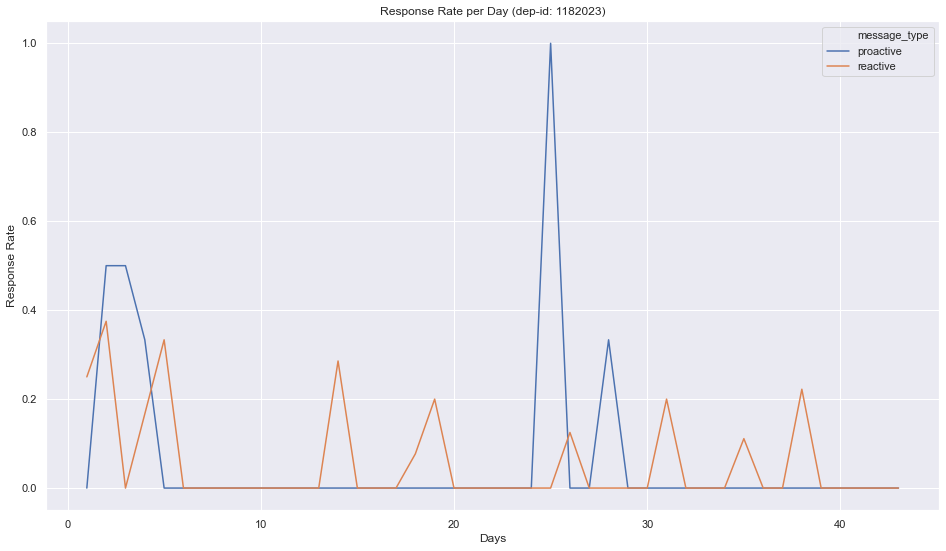

In [126]:
sns.set(rc={'figure.figsize':(16,9)})
ax = sns.lineplot(data=df, x="date_cnt", y="response_rate", hue='message_type')
ax.set(xlabel='Days',
       ylabel='Response Rate',
       title='Response Rate per Day (dep-id: {})'.format(dep_id))
plt.show()